In [1]:
# Make imports and define constants

import warnings
import chembl_querries
import constants
import numpy as np
import polars as pl
import joblib
import matplotlib.pyplot as plt
import constants
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from preprocess_data import preprocess_bioactivity_data
from get_chembl_data import *

BIOACTIVITIES_CSV = f"{constants.DATA_FOLDER}/chembl_gpcr_bioactivities.csv"
PROCESSED_BIOACTIVITIES = f"{constants.DATA_FOLDER}/chembl_gpcr.parquet"
MODEL_SAVE_PATH = f"{constants.DATA_FOLDER}/standard_value_predictor.pkl"

In [ ]:
# Fetch data and save it to a csv file

querry = chembl_querries.GET_UNIPROT_BIOACTIVITES_FOR_GPCR
run_chembl_querry(querry, BIOACTIVITIES_CSV)

In [2]:
# Preprocess the csv data and save it to a parquet file.

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    preprocess_bioactivity_data(BIOACTIVITIES_CSV, PROCESSED_BIOACTIVITIES)

In [3]:
# Load the bioactivities parquet and split the data into training and test

activities = pl.read_parquet(PROCESSED_BIOACTIVITIES)

features = activities["fingerprint"].to_list()
label = activities.select(["standard_value"]).to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

#print(X_train)
print(y_train)

[2300.   161.3 2730.  ... 1256.  1000.  9400. ]


In [ ]:
# Add a scaler for the features

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [4]:
# Train the model and save it

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
joblib.dump(model, MODEL_SAVE_PATH)
print("training done")

training done


In [5]:
# Load the saved model and predict on the test set

with open(MODEL_SAVE_PATH, "rb") as file:
    model = joblib.load(file)

y_pred = model.predict(X_test)

In [6]:
# Compute the root mean squared error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
print(y_test)
print(y_pred)

RMSE: 167645605.18594706
[  7.5 125.  132.  ...  76.    3.7   2.7]
[2597.24806667 1417.73326817  205.14232833 ...  160.21202      27.92053
   46.98621215]


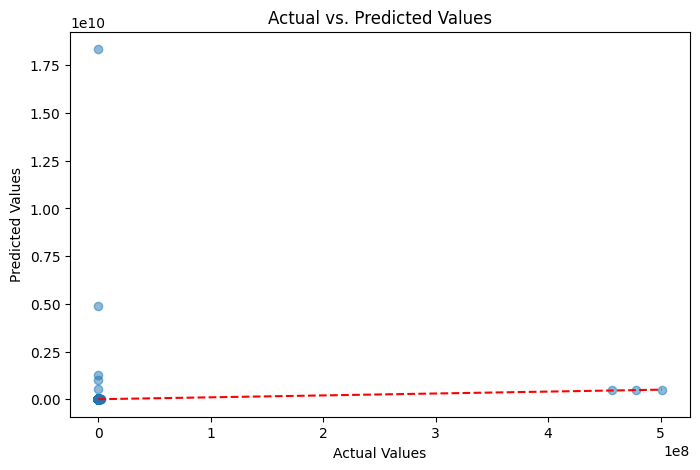

In [7]:
# Plot the model results

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.savefig(f"{constants.DATA_FOLDER}/RF_bioact_fp_regres.png")